In [ ]:
!pip install tenseal torch torchvision scikit-learn seaborn

Successfully imported libraries.
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Scanning dataset from: /content/drive/MyDrive/brain_tumor_dataset/
Dataset scanned. Found 1235 images.

Server is holding a balanced global validation set of 50 images.
Data successfully split among 3 clients in a Non-IID fashion.


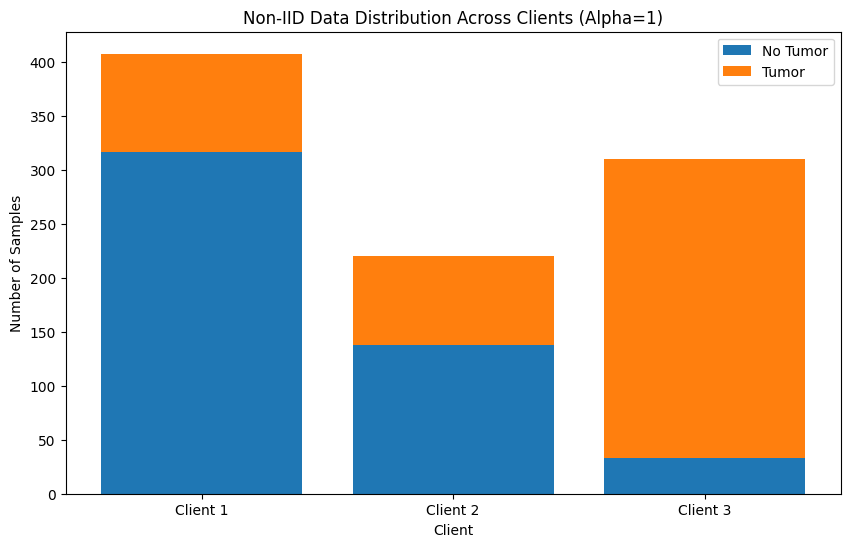


Setting up TenSEAL context for Homomorphic Encryption...
TenSEAL context created.

--- Starting Federated Learning with SCAFFOLD & Global Validation ---

=============== Round 1/15 ===============
-> Participating clients this round: [2 1 3]
--> Client 2 starting training...
   Client 2 global quality score: 0.6939
--> Client 1 starting training...
   Client 1 global quality score: 1.1050
--> Client 3 starting training...
   Client 3 global quality score: 0.8528

-> Server: Performing secure weighted aggregation...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, mat

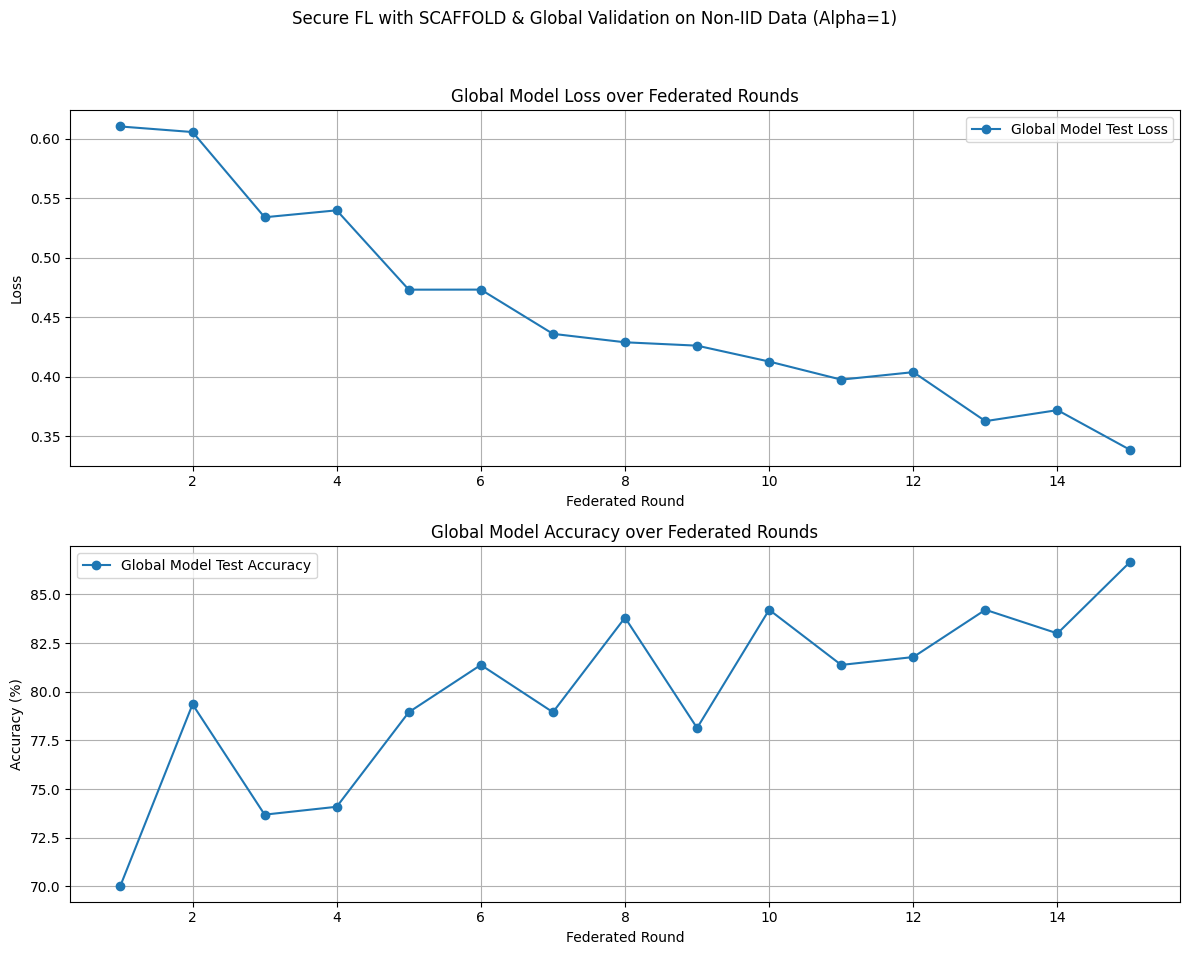

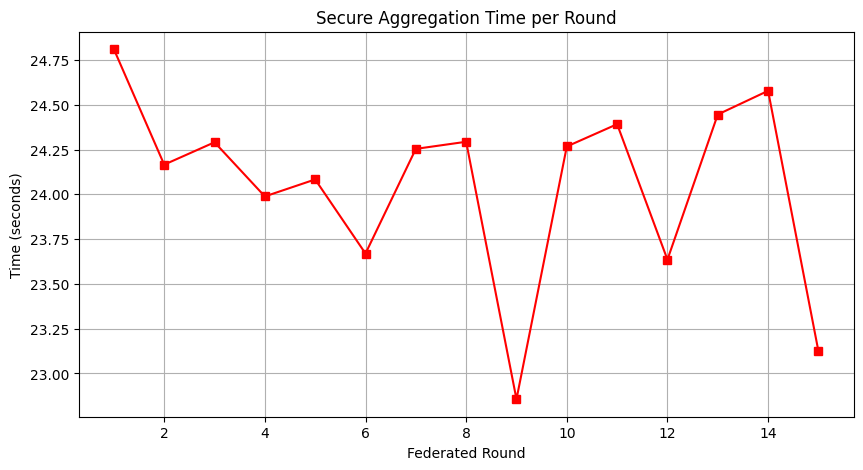


--- Client-Side Diagnosis/Inference Demonstration ---
Final trained model is ready for client-side use.

Diagnosis Result:
   - Actual Label: No Tumor
   - Model's Prediction: No Tumor


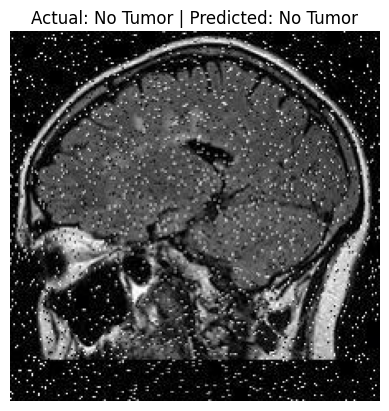

In [ ]:

import time
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import tenseal as ts
import copy
import gc # Garbage Collector interface

print("Successfully imported libraries.")

# --- Setup and Authentication ---
# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# ================================================
# 🔥 PROJECT UPGRADE: SCAFFOLD + Global Validation
# ================================================
NUM_CLIENTS = 3
NUM_ROUNDS = 15
EPOCHS_PER_CLIENT = 5 # SCAFFOLD is more efficient, requiring fewer local epochs
LEARNING_RATE = 0.01  # SCAFFOLD works well with standard SGD learning rates
CLIENT_FRACTION = 1.0
BATCH_SIZE = 16
DIRICHLET_ALPHA = 1
GLOBAL_VAL_SET_SIZE = 0.05 # Server holds back 5% of data as a balanced validation set
# ================================================

#
# Step 1: Define a custom Dataset class
#
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

#
# Step 2: Function to get image paths and labels
#
def get_image_paths_and_labels(image_directory):
    print(f"\nScanning dataset from: {image_directory}")
    image_paths, labels = [], []
    no_dir_path = os.path.join(image_directory, 'no')
    yes_dir_path = os.path.join(image_directory, 'yes')
    for label, path in enumerate([no_dir_path, yes_dir_path]):
        for image_name in os.listdir(path):
            if image_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(path, image_name))
                labels.append(label)
    print(f"Dataset scanned. Found {len(image_paths)} images.")
    return image_paths, labels

#
# Step 3: Define the PyTorch Model (MobileNetV3 with Fine-Tuning)
#
def get_mobilenetv3_model(num_classes=2):
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    # Make the fine-tuning layers and the classifier trainable
    for param in model.features[13:].parameters():
        param.requires_grad = True
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(True),
        nn.Dropout(p=0.6),
        nn.Linear(1024, num_classes),
    )
    return model

#
# Step 4: Client Update Functions (NOW WITH SCAFFOLD)
#
def scaffold_client_update(client_model, server_controls, client_controls, train_loader, device, lr, epochs):
    """
    🔥 NEW: Performs local training with the SCAFFOLD algorithm.
    """
    # Get only trainable parameters
    trainable_params = filter(lambda p: p.requires_grad, client_model.parameters())
    optimizer = optim.SGD(trainable_params, lr=lr)
    criterion = nn.CrossEntropyLoss()

    initial_weights = {name: param.clone().detach() for name, param in client_model.named_parameters() if param.requires_grad}

    client_model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = client_model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # SCAFFOLD gradient correction
            with torch.no_grad():
                for name, param in client_model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        control_diff = server_controls[name].to(device) - client_controls[name].to(device)
                        param.grad.data.add_(control_diff)

            optimizer.step()

    # Get the weight update (delta_y)
    final_weights = {name: param.clone().detach() for name, param in client_model.named_parameters() if param.requires_grad}
    delta_y = {name: final_weights[name] - initial_weights[name] for name in initial_weights}

    # Update the local control variate (c_i)
    new_client_controls = copy.deepcopy(client_controls)
    with torch.no_grad():
        # c_i^+ = c_i - c + 1/(K*lr) * (x - y) where (x-y) is -delta_y
        # We use steps = epochs * len(train_loader)
        steps = epochs * len(train_loader)
        for name in new_client_controls:
            term1 = client_controls[name].to(device) - server_controls[name].to(device)
            term2 = delta_y[name].to(device) / (steps * lr)
            new_client_controls[name] = term1 + term2

    # Get the change in the control variate (delta_c)
    delta_c = {name: new_client_controls[name] - client_controls[name].to(device) for name in client_controls}

    return delta_y, delta_c

#
# Function to create a Non-IID data split using a Dirichlet distribution
#
def dirichlet_split_non_iid(labels, n_clients, alpha=0.5):
    n_classes = len(np.unique(labels))
    labels = np.array(labels)
    label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
    class_indices = [np.where(labels == i)[0] for i in range(n_classes)]
    client_indices = [[] for _ in range(n_clients)]

    for c_idx, idcs in enumerate(class_indices):
        proportions = label_distribution[c_idx]
        proportions = proportions / proportions.sum()
        samples_per_client = (proportions * len(idcs)).astype(int)
        rem = len(idcs) - samples_per_client.sum()
        for i in range(rem):
            samples_per_client[i % n_clients] += 1
        np.random.shuffle(idcs)
        current_pos = 0
        for client_id in range(n_clients):
            num_samples = samples_per_client[client_id]
            client_indices[client_id].extend(idcs[current_pos : current_pos + num_samples])
            current_pos += num_samples
    return client_indices

#
# Step 5: Functions for Secure Aggregation & Evaluation
#
def encrypt_model_updates(updates, context):
    encrypted_updates = {}
    for name, params in updates.items():
        encrypted_updates[name] = ts.ckks_vector(context, params.flatten().tolist())
    return encrypted_updates

def server_secure_quality_aggregation(encrypted_updates_list, quality_scores, participating_indices, context):
    """
    🔥 NEW: Performs secure weighted aggregation based on unbiased quality scores.
    """
    epsilon = 1e-6
    inverse_losses = [1.0 / (score + epsilon) for score in quality_scores]
    total_inverse_loss = sum(inverse_losses)
    weights = [inv_loss / total_inverse_loss for inv_loss in inverse_losses]

    print("\n   Server calculated client weights based on global validation quality:")
    for i, w in enumerate(weights):
        client_id = participating_indices[i] + 1
        print(f"   - Client {client_id} weight: {w:.4f}")

    aggregated_updates = {}
    for name in encrypted_updates_list[0]:
        aggregated_updates[name] = encrypted_updates_list[0][name] * weights[0]
        for i in range(1, len(encrypted_updates_list)):
            aggregated_updates[name] += encrypted_updates_list[i][name] * weights[i]

    return aggregated_updates

def decrypt_and_apply_updates(model, encrypted_updates, context):
    with torch.no_grad():
        current_state_dict = model.state_dict()
        for name, enc_tensor in encrypted_updates.items():
            original_shape = current_state_dict[name].shape
            update_tensor = torch.tensor(enc_tensor.decrypt()).view(original_shape)
            current_state_dict[name] += update_tensor.to(current_state_dict[name].device)
        model.load_state_dict(current_state_dict)
    return model

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    test_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader.dataset)
    return avg_loss, accuracy


# --- Main Execution Block ---

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load dataset
IMAGE_DIRECTORY = '/content/drive/MyDrive/brain_tumor_dataset/'
image_paths, labels = get_image_paths_and_labels(IMAGE_DIRECTORY)

# 3. Define transforms
IMAGE_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Create datasets and dataloaders
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# 🔥 NEW: Create a global validation set held by the server
train_indices, global_val_indices = train_test_split(
    range(len(y_train)), test_size=GLOBAL_VAL_SET_SIZE, random_state=42, stratify=y_train
)
global_val_dataset = Subset(CustomImageDataset(X_train_paths, y_train, transform=test_transforms), global_val_indices)
global_val_loader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE)

# Use the remaining indices for client training data
client_train_paths = [X_train_paths[i] for i in train_indices]
client_y_train = [y_train[i] for i in train_indices]
full_train_dataset = CustomImageDataset(client_train_paths, client_y_train, transform=train_transforms)
print(f"\nServer is holding a balanced global validation set of {len(global_val_dataset)} images.")

test_dataset = CustomImageDataset(X_test_paths, y_test, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Split training data among clients using Dirichlet distribution for Non-IID
y_train_np = np.array(client_y_train)
client_indices = dirichlet_split_non_iid(y_train_np, n_clients=NUM_CLIENTS, alpha=DIRICHLET_ALPHA)

client_train_loaders = []
for c_indices in client_indices:
    train_subset = Subset(full_train_dataset, c_indices)
    client_train_loaders.append(DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True))
print(f"Data successfully split among {NUM_CLIENTS} clients in a Non-IID fashion.")

# Visualize the Non-IID data distribution
plt.figure(figsize=(10, 6))
class_names = ['No Tumor', 'Tumor']
client_names = [f'Client {i+1}' for i in range(NUM_CLIENTS)]
dist_data = []
for i in range(NUM_CLIENTS):
    if client_indices[i]:
        labels = y_train_np[client_indices[i]]
        dist_data.append([np.sum(labels == 0), np.sum(labels == 1)])
    else:
        dist_data.append([0, 0])
dist_data = np.array(dist_data)
bottom = np.zeros(NUM_CLIENTS)
for i, cls_name in enumerate(class_names):
    plt.bar(client_names, dist_data[:, i], bottom=bottom, label=cls_name)
    bottom += dist_data[:, i]
plt.title(f'Non-IID Data Distribution Across Clients (Alpha={DIRICHLET_ALPHA})')
plt.xlabel('Client')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()


# 6. Setup TenSEAL context for Homomorphic Encryption
print("\nSetting up TenSEAL context for Homomorphic Encryption...")
context = ts.context(
            ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
context.generate_galois_keys()
context.global_scale = 2**40
print("TenSEAL context created.")

# 7. Initialize Global Model and SCAFFOLD control variates
global_model = get_mobilenetv3_model()
trainable_param_names = [name for name, param in global_model.named_parameters() if param.requires_grad]
server_controls = {name: torch.zeros_like(param) for name, param in global_model.named_parameters() if param.requires_grad}
client_controls = [{name: torch.zeros_like(param) for name, param in global_model.named_parameters() if param.requires_grad} for _ in range(NUM_CLIENTS)]

fl_history = {'round': [], 'loss': [], 'accuracy': [], 'agg_time': []}

# --- Main Secure Federated Learning Loop ---
print("\n--- Starting Federated Learning with SCAFFOLD & Global Validation ---")

for round_num in range(NUM_ROUNDS):
    print(f"\n=============== Round {round_num + 1}/{NUM_ROUNDS} ===============")
    num_participating_clients = max(1, int(NUM_CLIENTS * CLIENT_FRACTION))
    participating_client_indices = np.random.choice(range(NUM_CLIENTS), size=num_participating_clients, replace=False)
    print(f"-> Participating clients this round: {participating_client_indices + 1}")

    client_updates_list = []
    client_delta_c_list = []
    quality_scores = []

    for i in participating_client_indices:
        print(f"--> Client {i+1} starting training...")
        client_model = copy.deepcopy(global_model).to(device)

        delta_y, delta_c = scaffold_client_update(
            client_model,
            server_controls,
            client_controls[i],
            client_train_loaders[i],
            device,
            lr=LEARNING_RATE,
            epochs=EPOCHS_PER_CLIENT
        )

        # 🔥 NEW: Server performs quality check on the unencrypted update
        with torch.no_grad():
            temp_model = copy.deepcopy(global_model)
            # Apply the update to the temp model to get the client's proposed model
            for name, param in temp_model.named_parameters():
                if name in delta_y:
                    param.data += delta_y[name].to(param.device)

            # Evaluate on the global validation set
            val_loss, _ = evaluate_model(temp_model, global_val_loader, device)
            quality_scores.append(val_loss)
            print(f"   Client {i+1} global quality score: {val_loss:.4f}")

        # Store updates for aggregation
        client_updates_list.append(delta_y)
        client_delta_c_list.append(delta_c)
        client_controls[i] = {name: val.to('cpu') for name, val in client_controls[i].items()} # ensure on cpu

        del client_model, delta_y, delta_c
        gc.collect()

    # --- Server-Side Operations ---
    print("\n-> Server: Performing secure weighted aggregation...")
    start_time = time.time()

    # Encrypt all the updates from the clients
    encrypted_client_updates = []
    for update in client_updates_list:
        encrypted_client_updates.append(encrypt_model_updates(update, context))

    # Perform secure quality-based aggregation
    aggregated_encrypted_updates = server_secure_quality_aggregation(
        encrypted_client_updates,
        quality_scores,
        participating_client_indices,
        context
    )

    # Decrypt the final aggregated update and apply it to the global model
    global_model = decrypt_and_apply_updates(global_model, aggregated_encrypted_updates, context)

    # Update server controls
    with torch.no_grad():
        avg_delta_c = {name: torch.zeros_like(server_controls[name]) for name in server_controls}
        for delta_c in client_delta_c_list:
            for name in avg_delta_c:
                avg_delta_c[name] += delta_c[name].to(avg_delta_c[name].device)

        for name in server_controls:
            server_controls[name] += (1/NUM_CLIENTS) * avg_delta_c[name]

    aggregation_time = time.time() - start_time
    print(f"   Secure weighted aggregation finished in {aggregation_time:.4f} seconds.")

    # --- Evaluation ---
    print("-> Simulating Evaluation Round...")
    test_loss, test_accuracy = evaluate_model(global_model, test_loader, device)
    fl_history['round'].append(round_num + 1); fl_history['loss'].append(test_loss)
    fl_history['accuracy'].append(test_accuracy); fl_history['agg_time'].append(aggregation_time)

    print(f"\n--- Round {round_num + 1} Summary ---")
    print(f"Global Model Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("================================\n")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print("\n--- Federated Learning with Client-Side Decryption Complete ---")

# --- Plotting Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(f"Secure FL with SCAFFOLD & Global Validation on Non-IID Data (Alpha={DIRICHLET_ALPHA})")
ax1.plot(fl_history['round'], fl_history['loss'], marker='o', label='Global Model Test Loss')
ax1.set_title('Global Model Loss over Federated Rounds'); ax1.set_xlabel('Federated Round'); ax1.set_ylabel('Loss')
ax1.grid(True); ax1.legend()
ax2.plot(fl_history['round'], fl_history['accuracy'], marker='o', label='Global Model Test Accuracy')
ax2.set_title('Global Model Accuracy over Federated Rounds'); ax2.set_xlabel('Federated Round'); ax2.set_ylabel('Accuracy (%)')
ax2.grid(True); ax2.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

plt.figure(figsize=(10, 5)); plt.plot(fl_history['round'], fl_history['agg_time'], marker='s', color='r')
plt.title('Secure Aggregation Time per Round'); plt.xlabel('Federated Round'); plt.ylabel('Time (seconds)')
plt.grid(True); plt.show()

# --- Client-Side Diagnosis Demonstration ---
print("\n--- Client-Side Diagnosis/Inference Demonstration ---")
final_model = copy.deepcopy(global_model)
final_model.to(device)
final_model.eval()
print("Final trained model is ready for client-side use.")
random_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[random_idx]
image_for_inference = test_image.unsqueeze(0).to(device)
with torch.no_grad():
    output = final_model(image_for_inference)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()
class_names = ['No Tumor', 'Tumor']
actual_class = class_names[test_label]
predicted_class = class_names[predicted_label]
print(f"\nDiagnosis Result:")
print(f"   - Actual Label: {actual_class}")
print(f"   - Model's Prediction: {predicted_class}")
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().squeeze().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor
plt.imshow(denormalize(test_image))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
plt.axis('off')
plt.show()


Successfully imported libraries.
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Scanning dataset from: /content/drive/MyDrive/brain_tumor_dataset/
Dataset scanned. Found 1235 images.

Server is holding a balanced global validation set of 50 images.
Data successfully split among 3 clients in a Non-IID fashion.


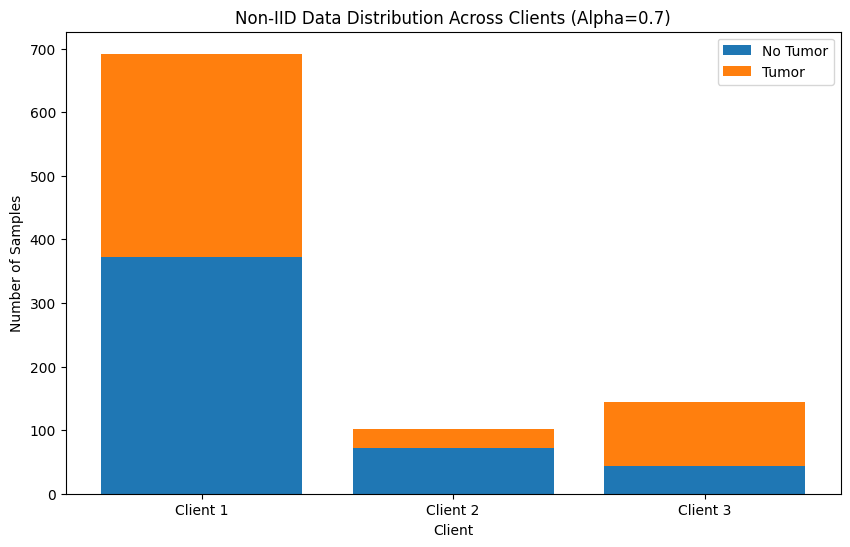


Setting up TenSEAL context for Homomorphic Encryption...
TenSEAL context created.

--- Starting Federated Learning with SCAFFOLD & Global Validation ---

=============== Round 1/20 ===============
-> Starting Round with Learning Rate: 0.001000
-> Participating clients this round: [2 1 3]
--> Client 2 starting training...
   Client 2 global quality score: 0.7923
--> Client 1 starting training...
   Client 1 global quality score: 0.7656
--> Client 3 starting training...
   Client 3 global quality score: 0.7246

-> Server: Performing secure weighted aggregation...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following ope

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(



=============== Round 2/20 ===============
-> Starting Round with Learning Rate: 0.000994
-> Participating clients this round: [1 2 3]
--> Client 1 starting training...
   Client 1 global quality score: 0.6951
--> Client 2 starting training...
   Client 2 global quality score: 0.6095
--> Client 3 starting training...
   Client 3 global quality score: 0.7855

-> Server: Performing secure weighted aggregation...
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_mo

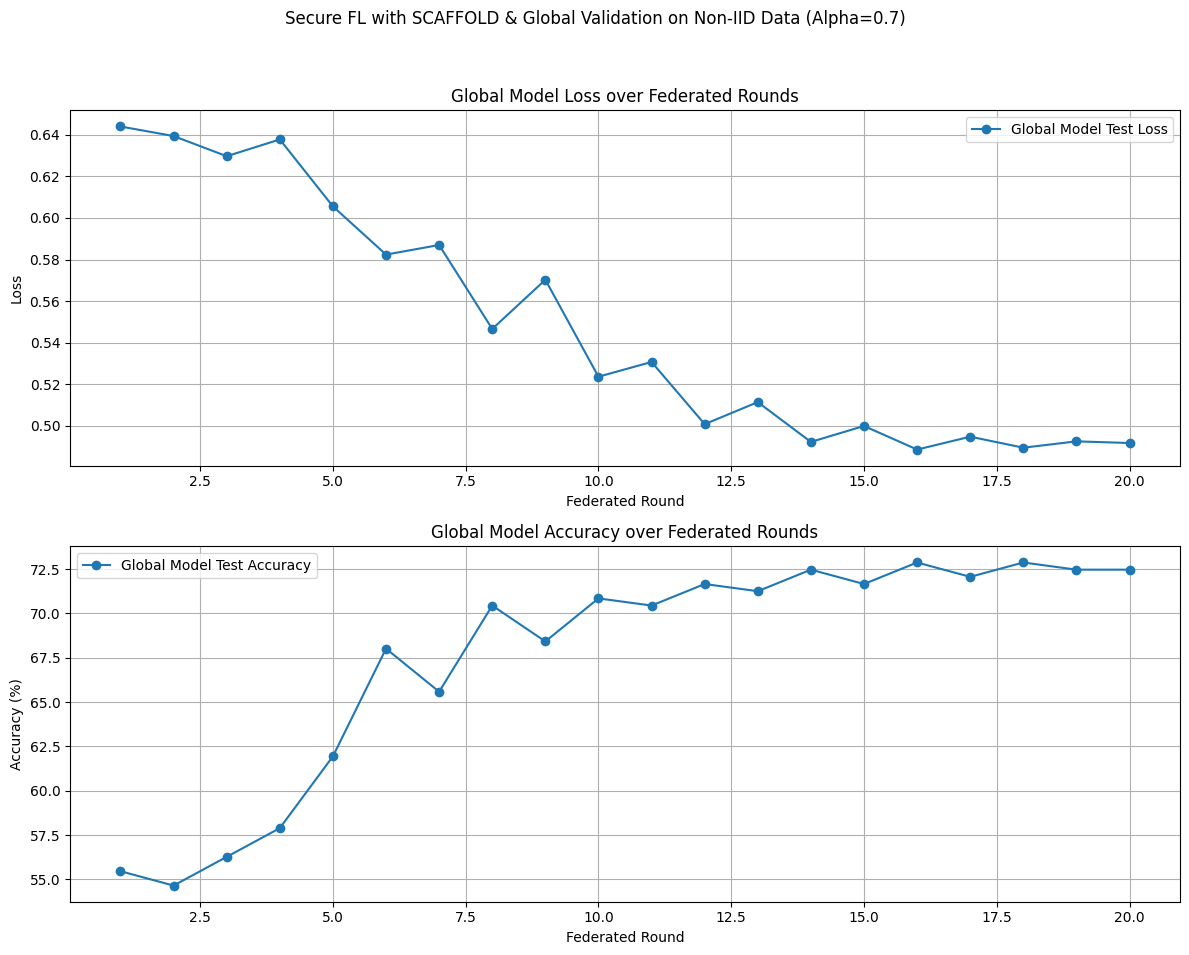

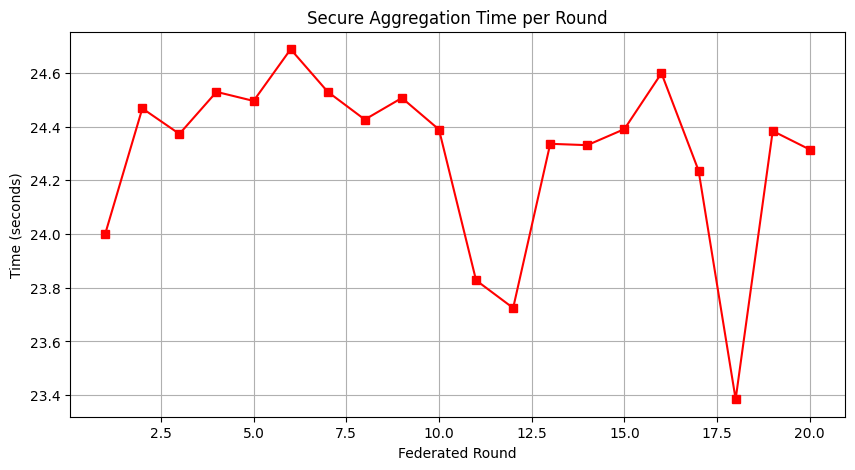


--- Client-Side Diagnosis/Inference Demonstration ---
Final trained model is ready for client-side use.

Diagnosis Result:
   - Actual Label: Tumor
   - Model's Prediction: No Tumor


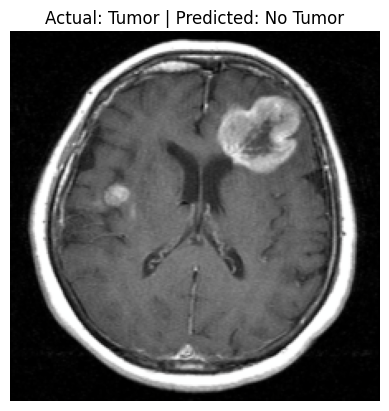

In [3]:
# ==============================================================================
# This is a complete, runnable script for a secure federated learning system.
#
# IMPORTANT: RUN THIS COMMAND IN A SEPARATE COLAB CELL BEFORE RUNNING THIS SCRIPT
# !pip install tenseal torch torchvision scikit-learn seaborn
# ==============================================================================

import time
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import tenseal as ts
import copy
import gc # Garbage Collector interface
import warnings

# Suppress the specific TenSEAL warning for cleaner logs
warnings.filterwarnings("ignore", message="The input does not fit in a single ciphertext")

print("Successfully imported libraries.")

# --- Setup and Authentication ---
# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# ================================================
# 🔥 PROJECT UPGRADE: Stabilizing Training for High Accuracy
# ================================================
NUM_CLIENTS = 3
NUM_ROUNDS = 20
EPOCHS_PER_CLIENT = 8
LEARNING_RATE = 0.001  # <--- UPDATED: Lower learning rate for more stable training
CLIENT_FRACTION = 1.0
BATCH_SIZE = 16
DIRICHLET_ALPHA = 0.7
GLOBAL_VAL_SET_SIZE = 0.05 # Server holds back 5% of data as a balanced validation set
# ================================================

#
# Step 1: Define a custom Dataset class
#
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

#
# Step 2: Function to get image paths and labels
#
def get_image_paths_and_labels(image_directory):
    print(f"\nScanning dataset from: {image_directory}")
    image_paths, labels = [], []
    no_dir_path = os.path.join(image_directory, 'no')
    yes_dir_path = os.path.join(image_directory, 'yes')
    for label, path in enumerate([no_dir_path, yes_dir_path]):
        for image_name in os.listdir(path):
            if image_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(path, image_name))
                labels.append(label)
    print(f"Dataset scanned. Found {len(image_paths)} images.")
    return image_paths, labels

#
# Step 3: Define the PyTorch Model (MobileNetV3 with Fine-Tuning)
#
def get_mobilenetv3_model(num_classes=2):
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    # Make the fine-tuning layers and the classifier trainable
    for param in model.features[13:].parameters():
        param.requires_grad = True
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(True),
        nn.Dropout(p=0.7), # <--- UPDATED: Increased dropout for stronger regularization
        nn.Linear(1024, num_classes),
    )
    return model

#
# Step 4: Client Update Functions (SCAFFOLD - Stabilized)
#
def scaffold_client_update(client_model, server_controls, client_controls, train_loader, device, lr, epochs):
    """
    Performs local training with the stabilized SCAFFOLD algorithm, including gradient clipping.
    """
    trainable_params = filter(lambda p: p.requires_grad, client_model.parameters())
    optimizer = optim.SGD(trainable_params, lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    initial_weights = {name: param.clone().detach() for name, param in client_model.named_parameters() if param.requires_grad}

    client_model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = client_model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            with torch.no_grad():
                for name, param in client_model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        param.grad.data.add_(server_controls[name].to(device) - client_controls[name].to(device))

            torch.nn.utils.clip_grad_norm_(client_model.parameters(), max_norm=1.0)

            optimizer.step()

    final_weights = {name: param.clone().detach() for name, param in client_model.named_parameters() if param.requires_grad}
    delta_y = {name: final_weights[name] - initial_weights[name] for name in initial_weights}

    new_client_controls = copy.deepcopy(client_controls)
    with torch.no_grad():
        steps = epochs * len(train_loader)
        if steps == 0:
            steps = 1

        for name in new_client_controls:
            update_term = -delta_y[name].to(device) / (steps * lr)
            new_client_controls[name] = client_controls[name].to(device) - server_controls[name].to(device) + update_term

    delta_c = {name: new_client_controls[name] - client_controls[name].to(device) for name in client_controls}

    return delta_y, delta_c, new_client_controls

#
# Function to create a Non-IID data split using a Dirichlet distribution
#
def dirichlet_split_non_iid(labels, n_clients, alpha=0.5):
    n_classes = len(np.unique(labels))
    labels = np.array(labels)
    label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
    class_indices = [np.where(labels == i)[0] for i in range(n_classes)]
    client_indices = [[] for _ in range(n_clients)]

    for c_idx, idcs in enumerate(class_indices):
        proportions = label_distribution[c_idx]
        proportions = proportions / proportions.sum()
        samples_per_client = (proportions * len(idcs)).astype(int)
        rem = len(idcs) - samples_per_client.sum()
        for i in range(rem):
            samples_per_client[i % n_clients] += 1
        np.random.shuffle(idcs)
        current_pos = 0
        for client_id in range(n_clients):
            num_samples = samples_per_client[client_id]
            client_indices[client_id].extend(idcs[current_pos : current_pos + num_samples])
            current_pos += num_samples
    return client_indices

#
# Step 5: Functions for Secure Aggregation & Evaluation
#
def encrypt_model_updates(updates, context):
    encrypted_updates = {}
    for name, params in updates.items():
        encrypted_updates[name] = ts.ckks_vector(context, params.flatten().tolist())
    return encrypted_updates

def server_secure_quality_aggregation(encrypted_updates_list, quality_scores, participating_indices, context):
    epsilon = 1e-6
    inverse_losses = [1.0 / (score + epsilon) for score in quality_scores]
    total_inverse_loss = sum(inverse_losses)
    weights = [inv_loss / total_inverse_loss for inv_loss in inverse_losses]

    print("\n   Server calculated client weights based on global validation quality:")
    for i, w in enumerate(weights):
        client_id = participating_indices[i] + 1
        print(f"   - Client {client_id} weight: {w:.4f}")

    aggregated_updates = {}
    for name in encrypted_updates_list[0]:
        aggregated_updates[name] = encrypted_updates_list[0][name] * weights[0]
        for i in range(1, len(encrypted_updates_list)):
            aggregated_updates[name] += encrypted_updates_list[i][name] * weights[i]

    return aggregated_updates

def decrypt_and_apply_updates(model, encrypted_updates, context):
    with torch.no_grad():
        current_state_dict = model.state_dict()
        for name, enc_tensor in encrypted_updates.items():
            original_shape = current_state_dict[name].shape
            update_tensor = torch.tensor(enc_tensor.decrypt()).view(original_shape)
            current_state_dict[name] += update_tensor.to(current_state_dict[name].device)
        model.load_state_dict(current_state_dict)
    return model

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    test_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader.dataset)
    return avg_loss, accuracy


# --- Main Execution Block ---

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load dataset
IMAGE_DIRECTORY = '/content/drive/MyDrive/brain_tumor_dataset/'
image_paths, labels = get_image_paths_and_labels(IMAGE_DIRECTORY)

# 3. Define transforms
IMAGE_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Create datasets and dataloaders
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Create a global validation set held by the server
train_indices, global_val_indices = train_test_split(
    range(len(y_train)), test_size=GLOBAL_VAL_SET_SIZE, random_state=42, stratify=y_train
)
global_val_dataset = Subset(CustomImageDataset(X_train_paths, y_train, transform=test_transforms), global_val_indices)
global_val_loader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE)

# Use the remaining indices for client training data
client_train_paths = [X_train_paths[i] for i in train_indices]
client_y_train = [y_train[i] for i in train_indices]
full_train_dataset = CustomImageDataset(client_train_paths, client_y_train, transform=train_transforms)
print(f"\nServer is holding a balanced global validation set of {len(global_val_dataset)} images.")

test_dataset = CustomImageDataset(X_test_paths, y_test, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Split training data among clients using Dirichlet distribution for Non-IID
y_train_np = np.array(client_y_train)
client_indices = dirichlet_split_non_iid(y_train_np, n_clients=NUM_CLIENTS, alpha=DIRICHLET_ALPHA)

client_train_loaders = []
for c_indices in client_indices:
    train_subset = Subset(full_train_dataset, c_indices)
    client_train_loaders.append(DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True))
print(f"Data successfully split among {NUM_CLIENTS} clients in a Non-IID fashion.")

# Visualize the Non-IID data distribution
plt.figure(figsize=(10, 6))
class_names = ['No Tumor', 'Tumor']
client_names = [f'Client {i+1}' for i in range(NUM_CLIENTS)]
dist_data = []
for i in range(NUM_CLIENTS):
    if client_indices[i]:
        labels = y_train_np[client_indices[i]]
        dist_data.append([np.sum(labels == 0), np.sum(labels == 1)])
    else:
        dist_data.append([0, 0])
dist_data = np.array(dist_data)
bottom = np.zeros(NUM_CLIENTS)
for i, cls_name in enumerate(class_names):
    plt.bar(client_names, dist_data[:, i], bottom=bottom, label=cls_name)
    bottom += dist_data[:, i]
plt.title(f'Non-IID Data Distribution Across Clients (Alpha={DIRICHLET_ALPHA})')
plt.xlabel('Client')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()


# 6. Setup TenSEAL context for Homomorphic Encryption
print("\nSetting up TenSEAL context for Homomorphic Encryption...")
context = ts.context(
            ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
context.generate_galois_keys()
context.global_scale = 2**40
print("TenSEAL context created.")

# 7. Initialize Global Model and SCAFFOLD control variates
global_model = get_mobilenetv3_model()
server_controls = {name: torch.zeros_like(param) for name, param in global_model.named_parameters() if param.requires_grad}
client_controls = [{name: torch.zeros_like(param) for name, param in global_model.named_parameters() if param.requires_grad} for _ in range(NUM_CLIENTS)]

fl_history = {'round': [], 'loss': [], 'accuracy': [], 'agg_time': []}

# Setup a dummy optimizer for the scheduler
dummy_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dummy_optimizer, T_max=NUM_ROUNDS, eta_min=1e-5)


# --- Main Secure Federated Learning Loop ---
print("\n--- Starting Federated Learning with SCAFFOLD & Global Validation ---")

for round_num in range(NUM_ROUNDS):
    print(f"\n=============== Round {round_num + 1}/{NUM_ROUNDS} ===============")

    current_lr = scheduler.get_last_lr()[0]
    print(f"-> Starting Round with Learning Rate: {current_lr:.6f}")

    num_participating_clients = max(1, int(NUM_CLIENTS * CLIENT_FRACTION))
    participating_client_indices = np.random.choice(range(NUM_CLIENTS), size=num_participating_clients, replace=False)
    print(f"-> Participating clients this round: {participating_client_indices + 1}")

    client_updates_list = []
    client_delta_c_list = []
    quality_scores = []

    for i in participating_client_indices:
        print(f"--> Client {i+1} starting training...")
        client_model = copy.deepcopy(global_model).to(device)

        delta_y, delta_c, new_c_i = scaffold_client_update(
            client_model,
            server_controls,
            client_controls[i],
            client_train_loaders[i],
            device,
            lr=current_lr,
            epochs=EPOCHS_PER_CLIENT
        )

        with torch.no_grad():
            temp_model = copy.deepcopy(global_model)
            for name, param in temp_model.named_parameters():
                if name in delta_y:
                    param.data += delta_y[name].to(param.device)

            val_loss, _ = evaluate_model(temp_model, global_val_loader, device)
            quality_scores.append(val_loss)
            print(f"   Client {i+1} global quality score: {val_loss:.4f}")

        client_updates_list.append(delta_y)
        client_delta_c_list.append(delta_c)
        client_controls[i] = {name: val.to('cpu') for name, val in new_c_i.items()}

        del client_model, delta_y, delta_c, new_c_i
        gc.collect()

    # --- Server-Side Operations ---
    print("\n-> Server: Performing secure weighted aggregation...")
    start_time = time.time()

    encrypted_client_updates = []
    for update in client_updates_list:
        encrypted_client_updates.append(encrypt_model_updates(update, context))

    aggregated_encrypted_updates = server_secure_quality_aggregation(
        encrypted_client_updates,
        quality_scores,
        participating_client_indices,
        context
    )

    global_model = decrypt_and_apply_updates(global_model, aggregated_encrypted_updates, context)

    with torch.no_grad():
        avg_delta_c = {name: torch.zeros_like(server_controls[name]) for name in server_controls}
        for delta_c in client_delta_c_list:
            for name in avg_delta_c:
                avg_delta_c[name] += delta_c[name].to(avg_delta_c[name].device)

        for name in server_controls:
            server_controls[name] += (1/NUM_CLIENTS) * avg_delta_c[name]

    aggregation_time = time.time() - start_time
    print(f"   Secure weighted aggregation finished in {aggregation_time:.4f} seconds.")

    # --- Evaluation ---
    print("-> Simulating Evaluation Round...")
    test_loss, test_accuracy = evaluate_model(global_model, test_loader, device)
    fl_history['round'].append(round_num + 1); fl_history['loss'].append(test_loss)
    fl_history['accuracy'].append(test_accuracy); fl_history['agg_time'].append(aggregation_time)

    print(f"\n--- Round {round_num + 1} Summary ---")
    print(f"Global Model Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("================================\n")

    scheduler.step()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print("\n--- Federated Learning with Client-Side Decryption Complete ---")

# --- Plotting Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(f"Secure FL with SCAFFOLD & Global Validation on Non-IID Data (Alpha={DIRICHLET_ALPHA})")
ax1.plot(fl_history['round'], fl_history['loss'], marker='o', label='Global Model Test Loss')
ax1.set_title('Global Model Loss over Federated Rounds'); ax1.set_xlabel('Federated Round'); ax1.set_ylabel('Loss')
ax1.grid(True); ax1.legend()
ax2.plot(fl_history['round'], fl_history['accuracy'], marker='o', label='Global Model Test Accuracy')
ax2.set_title('Global Model Accuracy over Federated Rounds'); ax2.set_xlabel('Federated Round'); ax2.set_ylabel('Accuracy (%)')
ax2.grid(True); ax2.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

plt.figure(figsize=(10, 5)); plt.plot(fl_history['round'], fl_history['agg_time'], marker='s', color='r')
plt.title('Secure Aggregation Time per Round'); plt.xlabel('Federated Round'); plt.ylabel('Time (seconds)')
plt.grid(True); plt.show()

# --- Client-Side Diagnosis Demonstration ---
print("\n--- Client-Side Diagnosis/Inference Demonstration ---")
final_model = copy.deepcopy(global_model)
final_model.to(device)
final_model.eval()
print("Final trained model is ready for client-side use.")
random_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[random_idx]
image_for_inference = test_image.unsqueeze(0).to(device)
with torch.no_grad():
    output = final_model(image_for_inference)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()
class_names = ['No Tumor', 'Tumor']
actual_class = class_names[test_label]
predicted_class = class_names[predicted_label]
print(f"\nDiagnosis Result:")
print(f"   - Actual Label: {actual_class}")
print(f"   - Model's Prediction: {predicted_class}")
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().squeeze().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor
plt.imshow(denormalize(test_image))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
plt.axis('off')
plt.show()


fedave-resnet

In [1]:
!pip install tenseal torch torchvision scikit-learn seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
# ==============================================================================
# IMPORTANT: RUN THIS COMMAND IN A SEPARATE COLAB CELL BEFORE RUNNING THIS SCRIPT
# !pip install tenseal torch torchvision scikit-learn seaborn
# ==============================================================================

import time
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import tenseal as ts
import copy
import gc # Garbage Collector interface
import warnings

# Suppress the specific TenSEAL warning for cleaner logs
warnings.filterwarnings("ignore", message="The input does not fit in a single ciphertext")


print("Successfully imported libraries.")

# --- Setup and Authentication ---
# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# ================================================
# 🔥 PROJECT UPGRADE: Global Validation Quality Weighting
# ================================================
NUM_CLIENTS = 3
NUM_ROUNDS = 15
EPOCHS_PER_CLIENT = 5
LEARNING_RATE = 0.001
CLIENT_FRACTION = 1.0
DP_ENABLED = False
DP_NOISE_MULTIPLIER = 0.05
BATCH_SIZE = 16
GLOBAL_VAL_SET_SIZE = 0.05 # Server holds back 5% of data as a balanced validation set
# ================================================

#
# Step 1: Define a custom Dataset class
#
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

#
# Step 2: Function to get image paths and labels
#
def get_image_paths_and_labels(image_directory):
    print(f"\nScanning dataset from: {image_directory}")
    image_paths, labels = [], []
    no_dir_path = os.path.join(image_directory, 'no')
    yes_dir_path = os.path.join(image_directory, 'yes')
    for label, path in enumerate([no_dir_path, yes_dir_path]):
        for image_name in os.listdir(path):
            if image_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(path, image_name))
                labels.append(label)
    print(f"Dataset scanned. Found {len(image_paths)} images.")
    return image_paths, labels

#
# Step 3: Define the PyTorch Model (🔥 UPDATED to ResNet34)
#
def get_resnet34_model(num_classes=2):
    """
    Loads a pre-trained ResNet34 model and replaces the final fully connected layer.
    """
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    # Freeze all the existing layers
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the final layer (fc)
    num_features = model.fc.in_features

    # Replace the final layer with a new trainable classifier
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
    )
    return model

#
# Step 4: Client Update Function
#
def client_update(client_model, train_loader, device, lr=0.001, epochs=1):
    # 🔥 UPDATED: Optimizer now trains the parameters of the 'fc' layer
    optimizer = optim.SGD(client_model.fc.parameters(), lr=lr, momentum=0.9)
    client_model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = client_model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
    # 🔥 UPDATED: Return the state dict of the 'fc' layer
    return client_model.fc.state_dict()

#
# Step 5: Functions for Secure Aggregation & Client-Side Decryption
#
def add_differential_privacy_noise(updates, noise_multiplier):
    with torch.no_grad():
        for name in updates:
            noise = torch.randn_like(updates[name]) * noise_multiplier
            updates[name] += noise
    return updates

def encrypt_model_updates(updates, context):
    encrypted_updates = {}
    for name, params in updates.items():
        encrypted_updates[name] = ts.ckks_vector(context, params.flatten().tolist())
    return encrypted_updates

def server_secure_quality_aggregation(encrypted_updates_list, quality_scores, participating_indices, context):
    """
    Performs secure weighted aggregation based on unbiased quality scores.
    """
    epsilon = 1e-6
    inverse_losses = [1.0 / (score + epsilon) for score in quality_scores]
    total_inverse_loss = sum(inverse_losses)
    weights = [inv_loss / total_inverse_loss for inv_loss in inverse_losses]

    print("\n   Server calculated client weights based on global validation quality:")
    for i, w in enumerate(weights):
        client_id = participating_indices[i] + 1
        print(f"   - Client {client_id} weight: {w:.4f}")

    # Aggregate the encrypted updates
    aggregated_updates = {}
    for name in encrypted_updates_list[0]:
        aggregated_updates[name] = encrypted_updates_list[0][name] * weights[0]
        for i in range(1, len(encrypted_updates_list)):
            aggregated_updates[name] += encrypted_updates_list[i][name] * weights[i]

    return aggregated_updates

def decrypt_and_apply_updates(model, encrypted_updates, context):
    """🔥 UPDATED: Decrypts the aggregated updates and applies them to the model's 'fc' layer."""
    with torch.no_grad():
        current_fc_state_dict = model.fc.state_dict()
        for name, enc_tensor in encrypted_updates.items():
            original_shape = current_fc_state_dict[name].shape
            update_tensor = torch.tensor(enc_tensor.decrypt()).view(original_shape)
            current_fc_state_dict[name] += update_tensor.to(current_fc_state_dict[name].device)
        model.fc.load_state_dict(current_fc_state_dict)
    return model


#
# Step 6: Client and Evaluation Functions
#
def client_decrypt_and_load_model(client_model, encrypted_global_model, context):
    """🔥 UPDATED: Decrypts the global model and loads it into the 'fc' layer."""
    decrypted_weights = {}
    with torch.no_grad():
        for name, enc_tensor in encrypted_global_model.items():
            decrypted_weights[name] = torch.tensor(enc_tensor.decrypt()).view_as(client_model.fc.state_dict()[name])

        current_fc_state_dict = client_model.fc.state_dict()
        current_fc_state_dict.update(decrypted_weights)
        client_model.fc.load_state_dict(current_fc_state_dict)
    return client_model

def evaluate_model(model, test_loader, device):
    """A standard, non-secure evaluation function."""
    model.to(device)
    model.eval()
    test_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader.dataset)
    return avg_loss, accuracy


# --- Main Execution Block ---

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load dataset
IMAGE_DIRECTORY = '/content/drive/MyDrive/brain_tumor_dataset/'
image_paths, labels = get_image_paths_and_labels(IMAGE_DIRECTORY)

# 3. Define transforms
IMAGE_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Create datasets and dataloaders
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Create a global validation set held by the server
train_indices, global_val_indices = train_test_split(
    range(len(y_train)), test_size=GLOBAL_VAL_SET_SIZE, random_state=42, stratify=y_train
)
global_val_dataset = Subset(CustomImageDataset(X_train_paths, y_train, transform=test_transforms), global_val_indices)
global_val_loader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE)

# Use the remaining indices for client training data
client_train_paths = [X_train_paths[i] for i in train_indices]
client_y_train = [y_train[i] for i in train_indices]
full_train_dataset = CustomImageDataset(client_train_paths, client_y_train, transform=train_transforms)
print(f"\nServer is holding a balanced global validation set of {len(global_val_dataset)} images.")


test_dataset = CustomImageDataset(X_test_paths, y_test, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Split training data among clients (using original StratifiedKFold for IID-like split)
client_indices = [[] for _ in range(NUM_CLIENTS)]
skf = StratifiedKFold(n_splits=NUM_CLIENTS, shuffle=True, random_state=42)
y_train_np = np.array(client_y_train)
for fold_idx, (_, client_idx) in enumerate(skf.split(client_train_paths, y_train_np)):
    client_indices[fold_idx] = client_idx
client_dataloaders = [DataLoader(Subset(full_train_dataset, indices), batch_size=BATCH_SIZE, shuffle=True) for indices in client_indices]
print(f"\nData successfully split among {NUM_CLIENTS} clients.")


# 6. Setup TenSEAL context
print("\nSetting up TenSEAL context for Homomorphic Encryption...")
context = ts.context(
            ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
context.generate_galois_keys()
context.global_scale = 2**40
print("TenSEAL context created.")

# 7. Initialize Global Model and Encrypt it
global_model = get_resnet34_model() # 🔥 UPDATED
trainable_weights = global_model.fc.state_dict() # 🔥 UPDATED
encrypted_global_model = encrypt_model_updates(trainable_weights, context)
print("Initial global model has been encrypted.")

fl_history = {'round': [], 'loss': [], 'accuracy': [], 'agg_time': []}

# --- Main Secure Federated Learning Loop ---
print("\n--- Starting Federated Learning with Global Validation Weighting ---")

for round_num in range(NUM_ROUNDS):
    print(f"\n=============== Round {round_num + 1}/{NUM_ROUNDS} ===============")

    num_participating_clients = max(1, int(NUM_CLIENTS * CLIENT_FRACTION))
    participating_client_indices = np.random.choice(range(NUM_CLIENTS), size=num_participating_clients, replace=False)
    print(f"-> Participating clients this round: {participating_client_indices + 1}")

    encrypted_client_updates_list = []
    quality_scores = []

    for i in participating_client_indices:
        print(f"--> Client {i+1} starting training...")

        client_model = copy.deepcopy(global_model).to(device)

        client_model = client_decrypt_and_load_model(client_model, encrypted_global_model, context)

        initial_weights = copy.deepcopy(client_model.fc.state_dict()) # 🔥 UPDATED
        final_fc_weights = client_update(client_model, client_dataloaders[i], device, lr=LEARNING_RATE, epochs=EPOCHS_PER_CLIENT)

        update_diff = {name: final_fc_weights[name] - initial_weights[name] for name in initial_weights}

        # Server performs quality check on the unencrypted update
        with torch.no_grad():
            temp_model = copy.deepcopy(global_model).to(device)
            # 🔥 UPDATED: Apply update to the 'fc' layer
            temp_fc_state = temp_model.fc.state_dict()
            for name, param in update_diff.items():
                temp_fc_state[name] += param
            temp_model.fc.load_state_dict(temp_fc_state)

            val_loss, _ = evaluate_model(temp_model, global_val_loader, device)
            quality_scores.append(val_loss)
            print(f"   Client {i+1} global quality score: {val_loss:.4f}")

        if DP_ENABLED:
            update_diff = add_differential_privacy_noise(update_diff, DP_NOISE_MULTIPLIER)

        encrypted_updates = encrypt_model_updates(update_diff, context)
        encrypted_client_updates_list.append(encrypted_updates)

        del client_model, initial_weights, final_fc_weights, update_diff, encrypted_updates
        gc.collect()


    # --- Server-Side Operations on Encrypted Data ---
    print("\n-> Server: Performing secure quality-weighted aggregation...")
    start_time = time.time()

    aggregated_encrypted_updates = server_secure_quality_aggregation(
        encrypted_client_updates_list,
        quality_scores,
        participating_client_indices,
        context
    )

    global_model = decrypt_and_apply_updates(global_model, aggregated_encrypted_updates, context)

    # Re-encrypt the new global model state for the next round
    encrypted_global_model = encrypt_model_updates(global_model.fc.state_dict(), context) # 🔥 UPDATED

    aggregation_time = time.time() - start_time
    print(f"   Secure weighted aggregation finished in {aggregation_time:.4f} seconds.")


    # --- Evaluation ---
    print("-> Simulating Evaluation Round...")
    test_loss, test_accuracy = evaluate_model(global_model, test_loader, device)

    fl_history['round'].append(round_num + 1); fl_history['loss'].append(test_loss)
    fl_history['accuracy'].append(test_accuracy); fl_history['agg_time'].append(aggregation_time)

    print(f"\n--- Round {round_num + 1} Summary ---")
    print(f"Global Model Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("================================\n")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print("\n--- Federated Learning Complete ---")

# --- Plotting Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle("Secure Federated Learning Convergence with ResNet34") # 🔥 UPDATED
ax1.plot(fl_history['round'], fl_history['loss'], marker='o', label='Global Model Test Loss')
ax1.set_title('Global Model Loss over Federated Rounds'); ax1.set_xlabel('Federated Round'); ax1.set_ylabel('Loss')
ax1.grid(True); ax1.legend()
ax2.plot(fl_history['round'], fl_history['accuracy'], marker='o', label='Global Model Test Accuracy')
ax2.set_title('Global Model Accuracy over Federated Rounds'); ax2.set_xlabel('Federated Round'); ax2.set_ylabel('Accuracy (%)')
ax2.grid(True); ax2.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

plt.figure(figsize=(10, 5)); plt.plot(fl_history['round'], fl_history['agg_time'], marker='s', color='r')
plt.title('Secure Aggregation Time per Round'); plt.xlabel('Federated Round'); plt.ylabel('Time (seconds)')
plt.grid(True); plt.show()


# --- Client-Side Diagnosis Demonstration ---
print("\n--- Client-Side Diagnosis/Inference Demonstration ---")

# Get the final trained model
final_model = copy.deepcopy(global_model)
final_model.to(device)
final_model.eval()
print("Final trained model is ready for client-side use.")

# Select a random image from the test set for diagnosis
random_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[random_idx]
image_for_inference = test_image.unsqueeze(0).to(device)

# Perform local inference
with torch.no_grad():
    output = final_model(image_for_inference)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()

# Display the results
class_names = ['No Tumor', 'Tumor']
actual_class = class_names[test_label]
predicted_class = class_names[predicted_label]

print(f"\nDiagnosis Result:")
print(f"  - Actual Label: {actual_class}")
print(f"  - Model's Prediction: {predicted_class}")

# To visualize the image, we need to denormalize it
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().squeeze().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

plt.imshow(denormalize(test_image))
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
plt.axis('off')
plt.show()


Successfully imported libraries.
Mounting Google Drive...
Mounted at /content/drive
Using device: cpu

Scanning dataset from: /content/drive/MyDrive/brain_tumor_dataset/
Dataset scanned. Found 1235 images.

Server is holding a balanced global validation set of 50 images.

Data successfully split among 3 clients.

Setting up TenSEAL context for Homomorphic Encryption...
TenSEAL context created.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
Initial global model has been encrypted.

--- Starting Federated Learning with Global Validation Weighting ---

=============== Round 1/15 ===============
-> Participating clients this round: [3 1 2]
--> Client 3 starting training...
   Client 3 global quality score: 0.6293
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
--> Client 1 starting training...
   Client 1 global quality score: 0.6585
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
--> Client 2 starting trainin

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2-2763146863.py", line 303, in <cell line: 0>
    final_fc_weights = client_update(client_model, client_dataloaders[i], device, lr=LEARNING_RATE, epochs=EPOCHS_PER_CLIENT)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2-2763146863.py", line 120, in client_update
    outputs = client_model(images)
              ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwarg

TypeError: object of type 'NoneType' has no len()